In [ ]:
#@title
# #@title
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

---

In [ ]:
# !kaggle datasets download -d retailrocket/ecommerce-dataset
# !mkdir -p ./data && unzip ecommerce-dataset.zip
# !mv ./*.csv ./data && rm ecommerce-dataset.zip
# !wget https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z
!unzip yoochoose-data.7z

Archive:  yoochoose-data.7z
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of yoochoose-data.7z or
        yoochoose-data.7z.zip, and cannot find yoochoose-data.7z.ZIP, period.


In [ ]:
# !mkdir /content/etc && git clone https://github.com/MemphisMeng/Brilliant-Recommendation-System.git /content/etc
!mkdir -p ./notebooks/etc && cp /content/etc/notebooks/*.ipynb ./notebooks/etc

---

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
events = pd.read_csv('./data/events.csv')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


---

In [ ]:
# label encode the events
events.event.replace(to_replace=dict(view=1, 
                                     addtocart=2, 
                                     transaction=3), 
                     inplace=True)

# drop the transcationid and timestamp columns that we don't need
events.drop(['transactionid', 'timestamp'],axis=1,inplace=True)

# label encode
from sklearn.preprocessing import LabelEncoder
le_users = LabelEncoder()
le_items = LabelEncoder()
events['visitorid'] = le_users.fit_transform(events['visitorid'])
events['itemid'] = le_items.fit_transform(events['itemid'])

# split into train, test and valid
train, test = train_test_split(events, train_size=0.9)
train, valid = train_test_split(train, train_size=0.9)
print('Train:{}, Valid:{}, Test:{}'.format(train.shape,
                                           valid.shape,
                                           test.shape))

Train:(2232441, 3), Valid:(248049, 3), Test:(275611, 3)


Matrix factorization model

In [ ]:
# store the number of visitors and items in a variable
n_users = events.visitorid.nunique()
n_items = events.itemid.nunique()

# set the number of latent factors
n_latent_factors = 5

# import the required layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Flatten

# create input layer for items
item_input = Input(shape=[1],name='Items')

# create embedding layer for items
item_embed = Embedding(n_items,
                       n_latent_factors,
                       name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

# create the input and embedding layer for users also
user_input = Input(shape=[1],name='Users')
user_embed = Embedding(n_users,
                       n_latent_factors, 
                       name='UsersEmbedding')(user_input)
user_vec = Flatten(name='UsersFlatten')(user_embed)

# create a layer for the dot product of both vector space representations
dot_prod = keras.layers.dot([item_vec, user_vec],axes=[1,1],
                             name='DotProduct')

# build and compile the model
model = keras.Model([item_input, user_input], dot_prod)
model.compile('adam', 'mse')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Items (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Users (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemsEmbedding (Embedding)      (None, 1, 5)         1175305     Items[0][0]                      
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 5)         7037900     Users[0][0]                      
____________________________________________________________________________________________

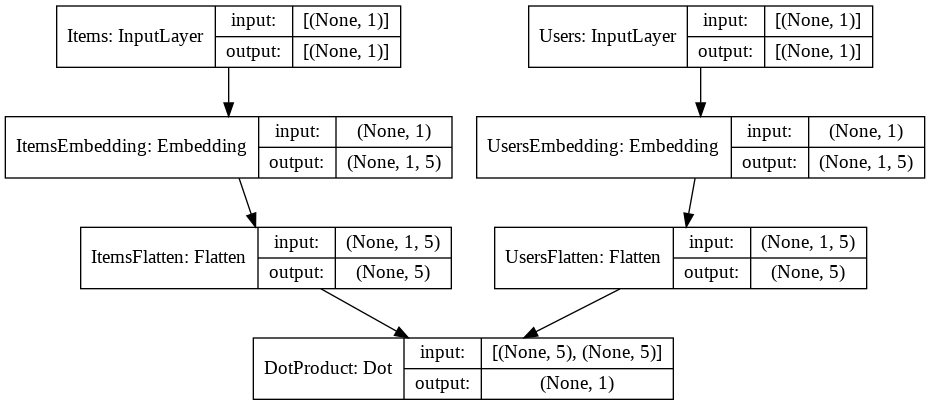

In [ ]:
keras.utils.plot_model(model, 
                       to_file='model.png', 
                       show_shapes=True, 
                       show_layer_names=True)
from IPython import display
display.display(display.Image('model.png'))

In [ ]:
# train and evaluate the model
model.fit([train.visitorid.values, train.itemid.values], train.event.values, epochs=50)
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

Epoch 1/50


InvalidArgumentError: ignored

Neural net model

In [ ]:
n_lf_visitor = 5
n_lf_item = 5

item_input = Input(shape=[1],name='Items')
item_embed = Embedding(n_items + 1,
                           n_lf_visitor, 
                           name='ItemsEmbedding')(item_input)
item_vec = Flatten(name='ItemsFlatten')(item_embed)

visitor_input = Input(shape=[1],name='Visitors')
visitor_embed = Embedding(n_visitors + 1, 
                              n_lf_item,
                              name='VisitorsEmbedding')(visitor_input)
visitor_vec = Flatten(name='VisitorsFlatten')(visitor_embed)

concat = keras.layers.concatenate([item_vec, visitor_vec], name='Concat')
fc_1 = Dense(80,name='FC-1')(concat)
fc_2 = Dense(40,name='FC-2')(fc_1)
fc_3 = Dense(20,name='FC-3', activation='relu')(fc_2)

output = Dense(1, activation='relu',name='Output')(fc_3)

optimizer = keras.optimizers.Adam(lr=0.001)
model = keras.Model([item_input, visitor_input], output)
model.compile(optimizer=optimizer,loss= 'mse')

model.fit([train.visitorid, train.itemid], train.event, epochs=50)
score = model.evaluate([test.visitorid, test.itemid], test.event)
print('mean squared error:', score)

---

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse.linalg import spsolve
from subprocess import check_output
from sklearn.model_selection import train_test_split

In [ ]:
events = pd.read_csv('./data/events.csv')
category_tree = pd.read_csv('./data/category_tree.csv')
items1 = pd.read_csv('./data/item_properties_part1.csv')
items2 = pd.read_csv('./data/item_properties_part2.csv')
items = pd.concat([items1, items2])

In [ ]:
user_activity_count = dict()
for row in events.itertuples():
    if row.visitorid not in user_activity_count:
        user_activity_count[row.visitorid] = {'view':0 , 'addtocart':0, 'transaction':0};
    if row.event == 'addtocart':
        user_activity_count[row.visitorid]['addtocart'] += 1 
    elif row.event == 'transaction':
        user_activity_count[row.visitorid]['transaction'] += 1
    elif row.event == 'view':
        user_activity_count[row.visitorid]['view'] += 1 

d = pd.DataFrame(user_activity_count)
dataframe = d.transpose()

# Activity range
dataframe['activity'] = dataframe['view'] + dataframe['addtocart'] + dataframe['transaction']

# removing users with only a single view
cleaned_data = dataframe[dataframe['activity']!=1]

cleaned_data.head()

,view,addtocart,transaction,activity
257597,2,0,0,2
992329,30,0,0,30
111016,2,0,0,2
483717,3,0,0,3
972639,2,0,0,2


Since the data is very sparse, data cleaning is required to reduce the inherent noise. Steps performed

- Found activity per item basis. Activity is view / addtocart / transaction
- Removed items with just a single view/activity (confirmed that, addtocard ones have both view+addtocart)
- Removed users with no activity
- Gave new itemId and userId to all users and items with some event attached and not removed in above steps.

---

In [ ]:
import os
import pandas as pd
import pickle
import datetime

In [ ]:
item_prop_1_df = pd.read_csv('./data/item_properties_part1.csv')
item_prop_1_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
item_prop_df = item_prop_1_df.copy()
item_prop_df['date'] = pd.to_datetime(item_prop_df['timestamp'], unit='ms', origin='unix')